In [1]:
%matplotlib notebook
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
import time
from qutip.ui.progressbar import BaseProgressBar

In [2]:
### DEFINE SYSTEM OPERATORS
N = 2 #for spin 1/2
N_spin = 5

qeye_list = [qeye(N) for i in range(N_spin)] #identity matrices
sigmax_list = [] #list of pauli operators for each spin
sigmay_list = []
sigmaz_list = []

for i in range(N_spin): #setup list of annihilation operators
    '''
    E.g. For three oscillators, this builds the list 
    [tensor(a,qeye,qeye), tensor(qeye,a,qeye), tensor(qeye,qeye,a)]
    '''
    
    temp1 = qeye_list.copy()
    temp1[i] = sigmax() 
    sigmax_list.append(tensor(temp1))
    
    temp2 = qeye_list.copy()
    temp2[i] = sigmay() 
    sigmay_list.append(tensor(temp2))
    
    temp3 = qeye_list.copy()
    temp3[i] = sigmaz() 
    sigmaz_list.append(tensor(temp3))

In [3]:
def spin_chain_H(N_spin,J,h):
    
    H_int = 0
    for j in range(N_spin-1):
        H_int += J/2 * (sigmax_list[j]*sigmax_list[j+1] + sigmay_list[j]*sigmay_list[j+1])
    
    H_field = 0
    for j in range(N_spin):
        H_field += h * sigmaz_list[j]
        
    return H_int + H_field

In [4]:
def stochastic_solve(H,gamma,times,rho0,L):

    ntraj=200
    #L = np.sqrt(gamma) * sigmaz_list[2] 
    
    #rho0 = tensor([fock(N, 0) for i in range(N_spin)])
    
    c_ops = []
    sc_ops = [L]
    e_ops = [sigmaz_list[0], sigmaz_list[-1]]
    #e_ops = []
    
    '''qutip 4.5
    opt = Options()
    #opt.store_states = False
    result = smesolve(H, rho0, times, c_ops, sc_ops,
                  e_ops, ntraj=ntraj, nsubsteps=50, solver='platen',
                  m_ops=[(L + L.dag())], dW_factors=[1/np.sqrt(gamma)],
                  method='homodyne', store_measurement=True, normalize=True,
                  map_func=parallel_map, options=opt)
    '''
    
    options = {
    "method": "platen",
    "dt": 0.001,
    "store_measurement": True,
    "store_states": True,
    "keep_runs_results": True,
    "map": "parallel",
}

    solver = SMESolver(H, sc_ops=sc_ops, heterodyne=False, options=options)
    solver.m_ops = [(L + L.dag())]
    solver.dW_factors = [np.sqrt(2)]
    result = solver.run(rho0, times, e_ops=e_ops, ntraj=ntraj)
    
    
    
    
    return result 

In [5]:
w,v = spin_chain_H(N_spin,3,1).eigenstates()

In [6]:
w

array([-9.19615242e+00, -8.19615242e+00, -7.19615242e+00, -6.19615242e+00,
       -6.00000000e+00, -5.00000000e+00, -4.19615242e+00, -4.00000000e+00,
       -3.19615242e+00, -3.00000000e+00, -2.19615242e+00, -2.00000000e+00,
       -1.19615242e+00, -1.00000000e+00, -1.00000000e+00,  5.32907052e-15,
        7.10542736e-15,  1.00000000e+00,  1.00000000e+00,  1.19615242e+00,
        2.00000000e+00,  2.19615242e+00,  3.00000000e+00,  3.19615242e+00,
        4.00000000e+00,  4.19615242e+00,  5.00000000e+00,  6.00000000e+00,
        6.19615242e+00,  7.19615242e+00,  8.19615242e+00,  9.19615242e+00])

In [7]:
v[1]

Quantum object: dims=[[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.93420700e-17]
 [ 0.00000000e+00]
 [-7.17220888e-32]
 [ 0.00000000e+00]
 [ 5.63654797e-17]
 [ 0.00000000e+00]
 [-2.93420700e-17]
 [ 9.46782584e-32]
 [ 8.07341576e-17]
 [-9.56900808e-32]
 [ 1.23669446e-16]
 [ 1.08109346e-17]
 [-2.88675135e-01]
 [ 0.00000000e+00]
 [-5.23641408e-33]
 [ 2.93420700e-17]
 [-1.97365255e-16]
 [-5.58762372e-32]
 [-2.99851826e-17]
 [ 5.44111118e-17]
 [ 5.00000000e-01]
 [-2.93420700e-17]
 [ 9.02125606e-17]
 [-4.72259773e-17]
 [-5.77350269e-01]
 [-9.17656460e-18]
 [ 5.00000000e-01]
 [-2.88675135e-01]
 [ 0.00000000e+00]]

In [8]:
liou_vec_list = [tensor(v[k],v[l].conj()) for k in range(2**N_spin) for l in range(2**N_spin)]
liou_vec_arr = np.reshape(liou_vec_list,(2**N_spin,2**N_spin))

In [9]:
gamma =0.01
L = np.sqrt(gamma) * sigmaz_list[2]
id_op = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
V = tensor(L, L.conj()) - 1/2 *(tensor(L.dag()*L,id_op) + tensor(id_op, (L.dag()*L).trans()))

In [10]:
M = np.reshape([liou_vec_arr[k,l].dag()*(V)*(liou_vec_arr[k,l]) for k in range(2**N_spin) for l in range(2**N_spin)] ,(2**N_spin,2**N_spin))

In [11]:
np.any(M==0)

True

In [12]:
np.where(M == 0)

(array([ 5, 26], dtype=int64), array([ 5, 26], dtype=int64))

In [48]:
v[5].dag() * L *v[5]

(-0.7071067811865476+0j)

In [49]:
v[26].dag() * L *v[26]

(0.7071067811865476+0j)

In [20]:
(sigmaz_list[2] *v[26]).full()

array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [27]:
(sigmaz_list[2]*tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,0),basis(2,1))).full()

array([[ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [-1.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j],
       [ 0.+0.j]])

In [13]:
H = spin_chain_H(N_spin,3,1)
times = np.linspace(0,10,501)
rho0 = 1/np.sqrt(2) *(v[5] + v[26])
#rho0 = tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,0),basis(2,1))
result = stochastic_solve(H,gamma,times,rho0,L)

10.0%. Run time:  10.41s. Est. time left: 00:00:01:33
20.0%. Run time:  15.01s. Est. time left: 00:00:01:00
30.0%. Run time:  19.22s. Est. time left: 00:00:00:44
40.0%. Run time:  23.32s. Est. time left: 00:00:00:34
50.0%. Run time:  27.30s. Est. time left: 00:00:00:27
60.0%. Run time:  31.86s. Est. time left: 00:00:00:21
70.0%. Run time:  35.85s. Est. time left: 00:00:00:15
80.0%. Run time:  39.51s. Est. time left: 00:00:00:09
90.0%. Run time:  43.88s. Est. time left: 00:00:00:04
100.0%. Run time:  46.73s. Est. time left: 00:00:00:00
Total run time:  47.27s


<IPython.core.display.Javascript object>


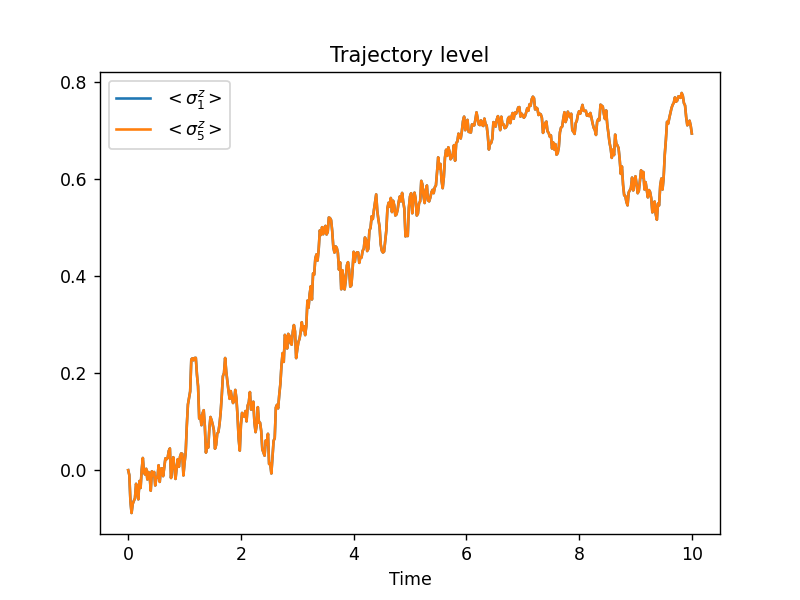

Text(0.5, 1.0, 'Trajectory level')

In [14]:
plt.figure()
plt.plot(times,result.expect[0][0],label='$<\sigma_1^z>$')
plt.plot(times,result.expect[1][0],label='$<\sigma_5^z>$')
plt.legend()
plt.xlabel('Time')
plt.title('Trajectory level')

<IPython.core.display.Javascript object>


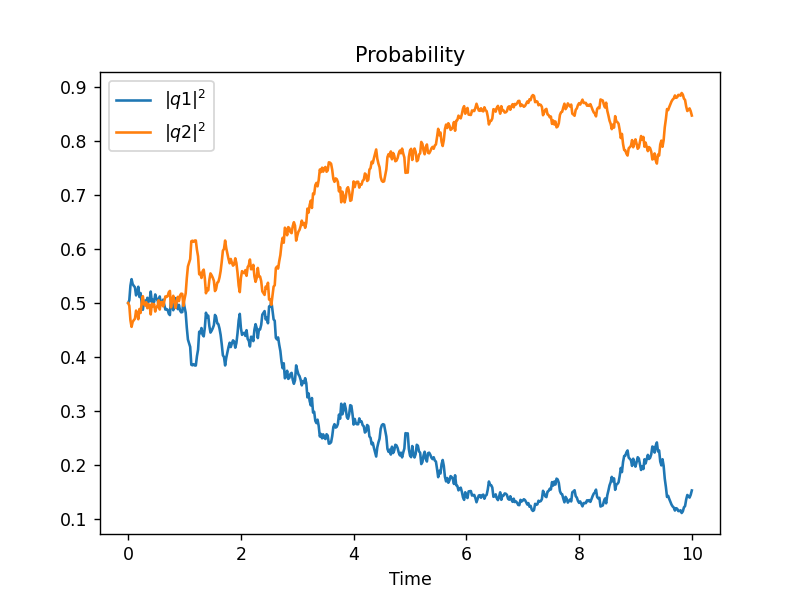

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Probability')

In [15]:
q1 = []
q2 = []
plt.figure()
for i in range(len(times)):
    q1.append(v[5].dag() *result.states[0][i] * v[5])
    q2.append(v[26].dag() * result.states[0][i] * v[26])
    
    
plt.plot(times,q1,label='$|q1|^2$')
plt.plot(times,q2,label='$|q2|^2$')
plt.legend()
plt.xlabel('Time')
plt.title('Probability')

<IPython.core.display.Javascript object>


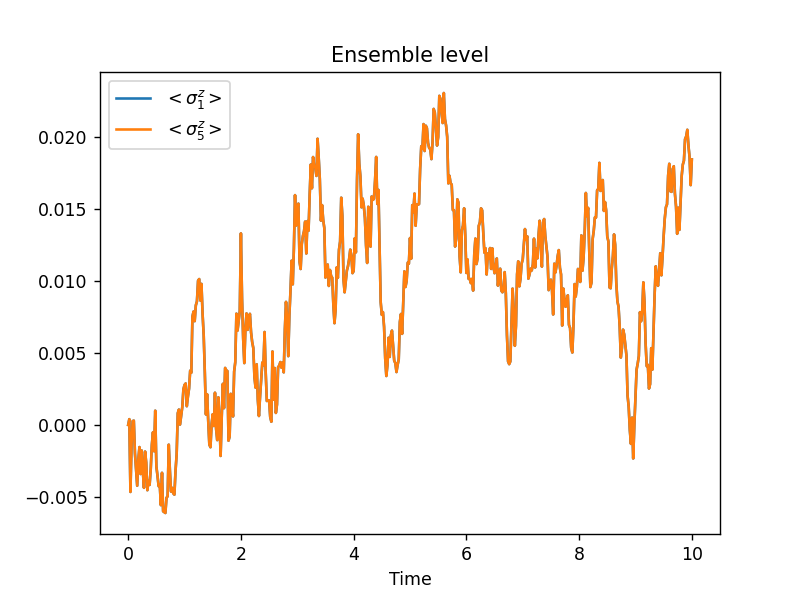

Text(0.5, 1.0, 'Ensemble level')

In [16]:
plt.figure()
plt.plot(times,result.expect[0].mean(axis=0),label='$<\sigma_1^z>$')
plt.plot(times,result.expect[1].mean(axis=0),label='$<\sigma_5^z>$')
plt.legend()
plt.xlabel('Time')
plt.title('Ensemble level')

In [18]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.1
Numpy Version:      1.26.4
Scipy Version:      1.13.0
Cython Version:     3.0.10
Matplotlib Version: 3.8.4
Python Version:     3.9.19
Number of CPUs:     20
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  C:\ProgramData\Anaconda3\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
